In [1]:
# imports
##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from scipy.sparse import coo_matrix, hstack

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

import tqdm
from tqdm import trange

In [2]:
# Read in the data
##
tweets = pd.read_csv("csv files/tweets.csv")

In [3]:
# Preview data
##
tweets.head()

,tweet_id,text,created_at,likes,text length,polarity
0,1242123434466979841,everyday might good there always something goo...,2020-03-23 16:17:58,1,57,0.4
1,1242123396684697603,next one week,2020-03-23 16:17:49,0,13,0.0
2,1242123373188124673,imagine people coming self something h,2020-03-23 16:17:44,0,38,0.0
3,1242086219519012867,never forget remind fight corona,2020-03-23 13:50:06,0,32,0.0
4,1242123367882330113,they provide food outdoor step well quarante,2020-03-23 16:17:43,0,44,0.0


In [4]:
tweets.tail()

,tweet_id,text,created_at,likes,text length,polarity
1185,1242064075405905921,emergency response team sent trace catholic pr...,2020-03-23 12:22:06,4,73,0.113636
1186,1242064012797530112,time put mandatory hate happening,2020-03-23 12:21:51,1,33,-0.800000
1187,1242063970632163329,people lose trust governing becomes face choice,2020-03-23 12:21:41,1,47,0.000000
1188,1242063856727396352,incompetent wont die,2020-03-23 12:21:14,2,20,-0.350000
1189,1242063643883307008,next corona virus strain even deadly see lippi...,2020-03-23 12:20:23,1,58,-0.100000


# EDA
Exploring the data

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tweet_id     1190 non-null   int64  
 1   text         1182 non-null   object 
 2   created_at   1190 non-null   object 
 3   likes        1190 non-null   int64  
 4   text length  1190 non-null   int64  
 5   polarity     1190 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 55.9+ KB


In [6]:
tweets.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,1190.0,1.242092e+18,1.612207e+13,1.242064e+18,1.242078e+18,1.242092e+18,1.242103e+18,1.242123e+18
likes,1190.0,9.109244e-01,1.320269e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01
text length,1190.0,3.597059e+01,1.683447e+01,0.000000e+00,2.300000e+01,3.650000e+01,4.800000e+01,8.500000e+01
polarity,1190.0,5.597235e-02,2.477956e-01,-1.000000e+00,0.000000e+00,0.000000e+00,1.363636e-01,1.000000e+00


In [7]:
# Checking for missing data
##
if tweets.isnull().values.any() == True:
    print("There is missing data. \nThe missing data points are as follows:\n", tweets.isnull().sum())
else:
    print("There is no missing data points.")

There is missing data. 
The missing data points are as follows:
 tweet_id       0
text           8
created_at     0
likes          0
text length    0
polarity       0
dtype: int64


In [8]:
# Dropping the missing data points row-wise
##
tweets.dropna(axis=0, inplace=True)

In [9]:
# Reset index
##
tweets.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='text length', ylabel='Density'>

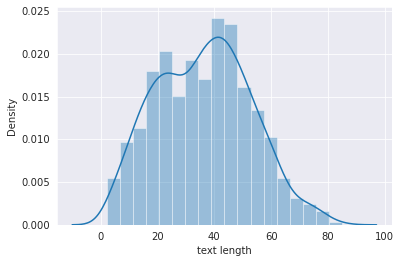

In [10]:
# Distribution of text length
##
sns.distplot(tweets['text length'])

In [11]:
# No. of unique number_of_likes and the corresponding count
##
tweets['likes'].value_counts()

0     587
1     341
2     150
3      49
4      31
6       8
5       6
7       4
10      2
8       2
11      1
9       1
Name: likes, dtype: int64

<AxesSubplot:xlabel='likes', ylabel='count'>

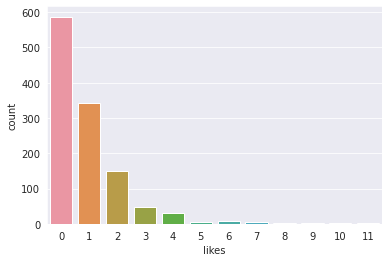

In [12]:
# Countplot of tweet likes
##
sns.countplot(x=tweets['likes'])

## Feature Engineering

In [13]:
# Let's classify sentiment as negative, neutral or positive
##
tweets['sentiment'] = np.nan

for i in trange(len(tweets)):
    if tweets['polarity'][i] < 0:
        tweets['sentiment'][i] = 'negative'
    elif tweets['polarity'][i] == 0:
        tweets['sentiment'][i] = 'neutral'
    else:
        tweets['sentiment'][i] = 'positive'

# Preview tweets
tweets.sample(15)

100%|██████████| 1182/1182 [00:00<00:00, 3181.71it/s]


,tweet_id,text,created_at,likes,text length,polarity,sentiment
580,1242097938257580032,still shouting attract,2020-03-23 14:36:40,0,22,0.000000,neutral
801,1242090232964669442,let get straight let country priest later trav...,2020-03-23 14:06:03,2,56,0.100000,positive
1181,1242063643883307008,next corona virus strain even deadly see lippi...,2020-03-23 12:20:23,1,58,-0.100000,negative
989,1242078515396259842,say dont advertise u ready thinking miracle,2020-03-23 13:19:29,1,43,0.200000,positive
109,1242119552185614336,vulnerable people people b basic income vat es...,2020-03-23 16:02:33,0,58,0.050000,positive
759,1242091822429679617,thought issue sorted relationship current need...,2020-03-23 14:12:22,0,59,0.000000,neutral
457,1242073259253866502,well put let understand right trying,2020-03-23 12:58:36,0,36,0.285714,positive
352,1242107117735198720,imagine carrying fight play,2020-03-23 15:13:08,0,27,0.000000,neutral
1009,1242077333969928193,negative economical impact that leaving open life,2020-03-23 13:14:47,1,49,0.000000,neutral
431,1242074240117071875,lost de moment fast,2020-03-23 13:02:30,0,19,0.200000,positive


In [14]:
# Creating the target variable based off of the sentiment column
##
mapper = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}

tweets['target'] = tweets['sentiment'].map(mapper)

# Preview
tweets.sample(15)

,tweet_id,text,created_at,likes,text length,polarity,sentiment,target
640,1242096244350242816,religiosity number curse,2020-03-23 14:29:56,0,24,0.000,neutral,0
1101,1242070386071818243,among resolved make use,2020-03-23 12:47:11,0,23,0.000,neutral,0
194,1242068120627482624,every day pas roughly staff working everyday,2020-03-23 12:38:11,1,44,-0.150,negative,-1
365,1242077487011676163,u go back lord u could,2020-03-23 13:15:24,0,22,0.000,neutral,0
912,1242083768246177794,hand powerful buy even pastor,2020-03-23 13:40:21,2,29,0.300,positive,1
1003,1242077748782391297,full bed whole area mess plus,2020-03-23 13:16:26,0,29,0.125,positive,1
1025,1242076538025259009,eliminate automatically,2020-03-23 13:11:37,0,23,0.000,neutral,0
493,1242101051093856261,dear foremost need test whoever posted could dont,2020-03-23 14:49:02,2,49,0.000,neutral,0
19,1242122752032718849,dont understand pleading like fare threaten hi,2020-03-23 16:15:16,1,46,0.000,neutral,0
81,1242113897286578182,end day stop write grateful middle could,2020-03-23 15:40:05,0,40,0.000,neutral,0


In [15]:
# Create another feature wordcount and compare its distribution with that of text length
# to see which best fits as a feature to be used in the model
##
tweets['word count'] = tweets['text'].apply(lambda text: len(text.split()))

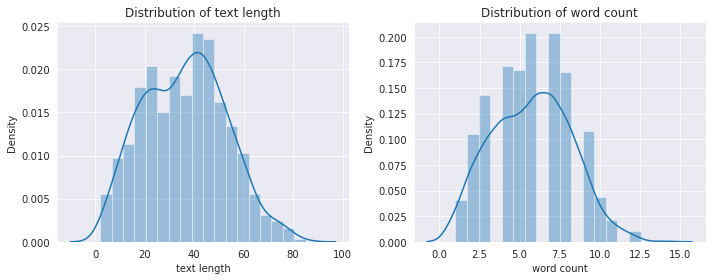

In [16]:
# Comparing the two distributions
##
fig, axes = plt.subplots(ncols=2, figsize=(10,4))

sns.distplot(tweets['text length'], ax=axes[0])
axes[0].set_title("Distribution of text length")

sns.distplot(tweets['word count'], ax=axes[1])
axes[1].set_title("Distribution of word count")

plt.tight_layout()

Seems that the two distributions have an identical pattern  
We'll use both features in the model building phase

In [17]:
tweets.head()

,tweet_id,text,created_at,likes,text length,polarity,sentiment,target,word count
0,1242123434466979841,everyday might good there always something goo...,2020-03-23 16:17:58,1,57,0.4,positive,1,9
1,1242123396684697603,next one week,2020-03-23 16:17:49,0,13,0.0,neutral,0,3
2,1242123373188124673,imagine people coming self something h,2020-03-23 16:17:44,0,38,0.0,neutral,0,6
3,1242086219519012867,never forget remind fight corona,2020-03-23 13:50:06,0,32,0.0,neutral,0,5
4,1242123367882330113,they provide food outdoor step well quarante,2020-03-23 16:17:43,0,44,0.0,neutral,0,7


## Model Building

In [18]:
# BOW (bag of words)
##
cv = CountVectorizer(analyzer='word')

cv.fit(tweets['text'])

CountVectorizer()

In [19]:
# Preview vocabulary and the number of vocab words
##
print(len(cv.vocabulary_))

1958


In [21]:
list(cv.vocabulary_)[:10]

['everyday',
 'might',
 'good',
 'there',
 'always',
 'something',
 'day',
 'could',
 'next',
 'one']

In [22]:
# Example transforming a single text
##
print(cv.transform([tweets['text'][0]]))

  (0, 58)	1
  (0, 374)	1
  (0, 420)	1
  (0, 580)	1
  (0, 724)	2
  (0, 1072)	1
  (0, 1599)	1
  (0, 1724)	1


In [23]:
# Example getting the feature name by index
##
cv.get_feature_names()[724]

'good'

In [24]:
# Transforming the whole BOW to a sparse matrix
##
bow_text = cv.transform(tweets['text'])

In [25]:
# Non-zero occurrences
##
bow_text.nnz

6455

In [26]:
# tfidf weighting
##
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(bow_text)

TfidfTransformer()

In [27]:
# Example transforming a single bow
##
print(tfidf_transformer.transform(cv.transform([tweets['text'][0]])))

  (0, 1724)	0.3537881182770148
  (0, 1599)	0.31966304511247007
  (0, 1072)	0.31025800282988647
  (0, 724)	0.5665166663853541
  (0, 580)	0.37661555463428
  (0, 420)	0.28325833319267707
  (0, 374)	0.1665231693082509
  (0, 58)	0.32502894965067836


In [28]:
# Example getting idf weight of a word
##
tfidf_transformer.idf_[cv.vocabulary_['good']]

5.0312864262549635

In [29]:
# Transforming the whole sparse matrix
##
tfidf_text = tfidf_transformer.transform(bow_text)

Adding 'text length' and 'word count' as features to the model  
We'll stack the features to the sparse matrix horizontally

In [30]:
"""# Transforming the two columns into sparse matrices
##
txt_length = coo_matrix(tweets['text length']).reshape(1182,1)
wrd_cnt = coo_matrix(tweets['word count']).reshape(1182,1)

features = hstack([tfidf_text, txt_length, wrd_cnt])

# Preview difference in shapes
print("Shape of text column sparse matrix: ", tfidf_text.shape)
print("Shape of concatenated features sparse matrix: ", features.shape)"""

'# Transforming the two columns into sparse matrices\n##\ntxt_length = coo_matrix(tweets[\'text length\']).reshape(1182,1)\nwrd_cnt = coo_matrix(tweets[\'word count\']).reshape(1182,1)\n\nfeatures = hstack([tfidf_text, txt_length, wrd_cnt])\n\n# Preview difference in shapes\nprint("Shape of text column sparse matrix: ", tfidf_text.shape)\nprint("Shape of concatenated features sparse matrix: ", features.shape)'

In [31]:
features = tfidf_text

## Comparing different classification models:  
- Logistic Regression
- Linear SVC (svm)
- Random Forest Classifier
- Xgboost Classifier

In [32]:
# Splitting data into train and test splits
##
X_train, X_test, y_train, y_test = train_test_split(features, tweets['target'], test_size=0.2)

In [33]:
# Initialize models
##
lr = LogisticRegression(C=2.0, class_weight=None, dual=False, max_iter=100)

svc = LinearSVC(C=2.0, class_weight=None, dual=False, max_iter=100)

rfc = RandomForestClassifier(bootstrap=False, class_weight=None, 
                             criterion='entropy', min_samples_split=6, n_estimators=160, warm_start=False)

xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=3)

In [34]:
# Train models
##
lr.fit(X_train, y_train)

svc.fit(X_train, y_train)

rfc.fit(X_train, y_train)

xgb.fit(X_train,y_train)

[20:10:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
# Make predictions
##
lr_pred = lr.predict(X_test)

svc_pred = svc.predict(X_test)

rfc_pred = rfc.predict(X_test)

xgb_pred = xgb.predict(X_test)

In [36]:
# Evaluate models
##
print("Logistic Regression \n----------------------------------")
print(confusion_matrix(y_test, lr_pred))
print(classification_report(y_test, lr_pred))
print("Linear SVC \n---------------------------------")
print(confusion_matrix(y_test, svc_pred))
print(classification_report(y_test, svc_pred))
print("Random Forest Classifier \n----------------------------------")
print(confusion_matrix(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))
print("Xgboost Classifier \n----------------------------------")
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

Logistic Regression 
----------------------------------
[[  6  21   2]
 [  0 119   8]
 [  1  40  40]]
              precision    recall  f1-score   support

          -1       0.86      0.21      0.33        29
           0       0.66      0.94      0.78       127
           1       0.80      0.49      0.61        81

    accuracy                           0.70       237
   macro avg       0.77      0.55      0.57       237
weighted avg       0.73      0.70      0.66       237

Linear SVC 
---------------------------------
[[ 11  16   2]
 [  2 114  11]
 [  4  30  47]]
              precision    recall  f1-score   support

          -1       0.65      0.38      0.48        29
           0       0.71      0.90      0.79       127
           1       0.78      0.58      0.67        81

    accuracy                           0.73       237
   macro avg       0.71      0.62      0.65       237
weighted avg       0.73      0.73      0.71       237

Random Forest Classifier 
------------------

In [38]:
cross_val_score(rfc, features, tweets['target'], cv=5)

array([0.76371308, 0.76371308, 0.77966102, 0.75847458, 0.74152542])

In [37]:
# Making sure that the models are not overfitting using cross val score metric with 5 folds
##
print("Logistic Regression \n------------------------- \nscore= ", cross_val_score(lr, features, tweets['target'], cv=5).mean())
print("\nLinear SVC \n------------------------- \nscore=", cross_val_score(svc, features, tweets['target'], cv=5).mean())
print("\nRandom Forest Classifier \n------------------------- \nscore=", cross_val_score(rfc, features, tweets['target'], cv=5).mean())
print("\nXgboost Classifier \n------------------------- \nscore=", cross_val_score(xgb, features, tweets['target'], cv=5).mean())

Logistic Regression 
------------------------- 
score=  0.6928913680898233

Linear SVC 
------------------------- 
score= 0.7284416791818638

Random Forest Classifier 
------------------------- 
score= 0.7563291139240507
[12:19:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:16] WARNING: 

In [38]:
# Random forest performed best
# That's a good score having in mind that the model is attempting to predict between three category classes

In [39]:
# saving model
from sklearn.pipeline import Pipeline
import pickle

# retrain
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('classifier', RandomForestClassifier(
    bootstrap=False, class_weight=None, criterion='entropy', min_samples_split=6,
    n_estimators=160, warm_start=False))])
pipe.fit(tweets.text, tweets.target)
pickle.dump(pipe, open('saved_model.pkl', 'wb'))

In [41]:
# load model
model = pickle.load(open('saved_model.pkl', 'rb'))

In [50]:
model.predict(["I don't know"])

array([0])

In [40]:
np.int(pipe.predict(["I love people."]))

1